In [1]:
#separate the sound
import moviepy.editor as me

video = me.VideoFileClip("C:/Users/Bojana/Desktop/Soft projekt/Subtitle_Correction/speech.video.mp4")
video.audio.write_audiofile("C:/Users/Bojana/Desktop/Soft projekt/Subtitle_Correction/speechAudio.wav",  fps=16000)
video.reader.close()
video.audio.reader.close_proc()

[MoviePy] Writing audio in C:/Users/Bojana/Desktop/Soft projekt/Subtitle_Correction/speechAudio.wav


100%|█████████████████████████████████████████████████████████████████████████████| 3488/3488 [00:04<00:00, 862.73it/s]


[MoviePy] Done.


In [2]:
#filter the sound
import matplotlib.pyplot as plt
import numpy as np
import wave
import sys
import math
import contextlib

input_file = 'speechAudio.wav'
output_file = 'filteredSpeech.wav'

cutOffFrequency = 500.0

def running_mean(x, windowSize):
  cumsum = np.cumsum(np.insert(x, 0, 0)) 
  return (cumsum[windowSize:] - cumsum[:-windowSize]) / windowSize

def interpret_wav(raw_bytes, n_frames, n_channels, sample_width, interleaved = True):

    if sample_width == 1:
        dtype = np.uint8 
    elif sample_width == 2:
        dtype = np.int16 

    channels = np.frombuffer(raw_bytes, dtype=dtype)

    channels.shape = (n_frames, n_channels)
    channels = channels.T

    return channels

with contextlib.closing(wave.open(input_file,'rb')) as spf:
    sampleRate = spf.getframerate()
    ampWidth = spf.getsampwidth()
    nChannels = spf.getnchannels()
    nFrames = spf.getnframes()

    # Extract Raw Audio from multi-channel Wav File
    signal = spf.readframes(nFrames*nChannels)
    spf.close()
    channels = interpret_wav(signal, nFrames, nChannels, ampWidth, True)

    freqRatio = (cutOffFrequency/sampleRate)
    N = int(math.sqrt(0.196196 + freqRatio**2)/freqRatio)

    filtered = running_mean(channels[0], N).astype(channels.dtype)

    wav_file = wave.open(output_file, "w")
    wav_file.setparams((1, ampWidth, sampleRate, nFrames, spf.getcomptype(), spf.getcompname()))
    wav_file.writeframes(filtered.tobytes('C'))
    wav_file.close()
    
print("Done!")

Done!


Loading...


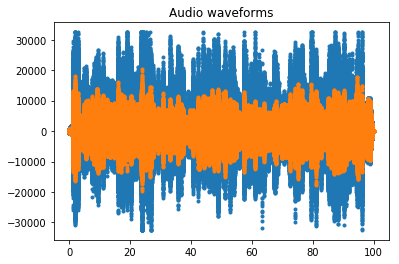

In [4]:
#plot 
import matplotlib.pyplot as plt
import numpy as np
from statistics import mean
import wave
import sys

plt.figure(1)

class Audio:
    def __init__(self, audio):
        self.audio = wave.open(audio,'r')
        self.signal = self.audio.readframes(-1)
        self.signal = np.frombuffer(self.signal, 'Int16')
        self.fr = self.audio.getframerate()
        self.time = np.linspace(0, 100, num=(len(self.signal)))
        self.fft = np.fft.fft(self.signal)

    def plot(self):
        plt.title("Audio waveforms")
        plt.plot(self.time, self.signal, '.')
        
print("Loading...")
gana = Audio('speechAudio.wav')
humm = Audio('filteredSpeech.wav')

gana.plot()
humm.plot()
plt.show()

In [5]:
#speech to text and writing in .srt
from google.cloud import speech_v1p1beta1 as speech
from google.cloud.speech_v1p1beta1 import enums
from google.cloud.speech_v1p1beta1 import types
from google.oauth2 import service_account
from datetime import datetime, timedelta

credentials = service_account.Credentials.from_service_account_file('sifra.json')

client = speech.SpeechClient(credentials=credentials)

uri = 'gs://soft_files/filteredSpeech.wav'

audio = types.RecognitionAudio(uri=uri)
config = types.RecognitionConfig(
    encoding=speech.enums.RecognitionConfig.AudioEncoding.LINEAR16,
    sample_rate_hertz=16000,
    language_code='en-US',
    audio_channel_count=1,
    enable_word_time_offsets=True)

operation = client.long_running_recognize(config, audio)

print('Waiting for operation to complete...')
response = operation.result()

block = 0
start_time = datetime(100,1,1,0,0,0)
firstTitle = 1

for i, result in enumerate(response.results):
    alternative = result.alternatives[0]
    start = result.alternatives[0].words[0].start_time;
    end = 0;
    for word_info in result.alternatives[0].words:
        end = word_info.end_time
    block+=1
    block_str = str(block)
    if firstTitle == 1:
        time_add = len(alternative.transcript.split())*0.3
        end_time = start_time + timedelta(0, end.seconds + end.nanos * 1e-9)
        begin_time = end_time - timedelta(0, time_add)
        s = end_time.strftime('%H:%M:%S,%f')
        s2 = begin_time.strftime('%H:%M:%S,%f')
        firstTitle = 2
        
    else:
        begin_time = start_time + timedelta(0, start.seconds + start.nanos * 1e-9)
        time_add = len(alternative.transcript.split())*0.3
        end_time = begin_time + timedelta(0, time_add)
        s = end_time.strftime('%H:%M:%S,%f')
        s2 = begin_time.strftime('%H:%M:%S,%f')
    
    with open("speechTitlovi.srt", "a") as f:
            f.write(block_str)
            f.write("\n")
            f.write(s2[:-3])
            f.write(" --> ")
            f.write(s[:-3])
            f.write("\n")
            f.write(alternative.transcript)
            f.write("\n")
            f.write("\n")
    
print("Done!")

Waiting for operation to complete...
Done!


In [6]:
#shifting subtitle
import pysrt
subs = pysrt.open('speechTitlovi.srt')
subs.shift(seconds=2) 
subs.save('speechShiftedTitlovi.srt')

print("Done!")

Done!


In [7]:
#compare original subtitle to shifted subtitle, and return it to correct state
from datetime import datetime
import time
class Title:
    def __init__(self, block, beginTime, endTime,transcript):
        self.block = block
        self.beginTime = beginTime
        self.endTime = endTime
        self.transcript = transcript

numb_original_begin = 0
      
with open("speechOriginal.srt", "r") as o:
    numb_line = 1
    for line in o:
        if numb_line == 2:
            a = line.split("-->")
            numb_line = numb_line + 1
            h,m,s = a[0].split(":")
            s1,s2 = s.split(",")
            numb_original_begin = timedelta(hours=int(h),minutes=int(m),seconds=int(s1), milliseconds = int(s2)).total_seconds()
        else:
            numb_line = numb_line + 1

titleList = []
with open("speechShiftedTitlovi.srt", "r") as f:
    numb_line = 1
    title = Title(0,"", "", "")
    for line in f:
        if numb_line == 1:
            title.block = line.strip()
            numb_line = numb_line + 1
        elif numb_line == 2:
            a = line.strip().split("-->")
            h,m,s = a[0].split(":")
            s1,s2 = s.split(",")
            numb_begin = timedelta(hours=int(h),minutes=int(m),seconds=int(s1), milliseconds = int(s2)).total_seconds()
            h2,m2,s2 = a[1].split(":")
            s3,s4 = s2.split(",")
            numb_end = timedelta(hours=int(h2),minutes=int(m2),seconds=int(s3), milliseconds = int(s4)).total_seconds()
            title.beginTime = numb_begin
            title.endTime = numb_end
            numb_line = numb_line + 1

        elif numb_line == 3:
            title.transcript = line.strip()
            numb_line = numb_line + 1

        else:
            titleList.append(title)
            title = Title(0,"", "", "")
            numb_line = 1

first = True
diffrence = 0
newList = []
for t in titleList:
    if first:
        diffrence = numb_original_begin - t.beginTime
        t.beginTime = "0" + str(timedelta(seconds=numb_original_begin)).replace('.',',')[:-3]
        num_end = t.endTime + diffrence
        t.endTime = "0" + str(timedelta(seconds=num_end)).replace('.',',')[:-3]
        newList.append(t)
        first = False

    else:
        num_begin = t.beginTime + diffrence
        t.beginTime = "0" + str(timedelta(seconds=num_begin)).replace('.',',')[:-3]
        num_end = t.endTime + diffrence
        t.endTime = "0" + str(timedelta(seconds=num_end)).replace('.',',')[:-3]
        newList.append(t)
    
with open("newTitle.srt", "w") as new:
    for ti in newList:
        new.write(ti.block)
        new.write("\n")
        new.write(ti.beginTime)
        new.write(" --> ")
        new.write(ti.endTime)
        new.write("\n")
        new.write(ti.transcript)
        new.write("\n")
        new.write("\n")
        
print("Finished!")

Finished!


In [10]:
#Checking the matching percentage of two .srt files (text generated inside files)
#Checking the start time of both .srt files (by how much they differ)
import pysrt
from difflib import SequenceMatcher

def percentage_match(a, b):
    return SequenceMatcher(None, a, b).ratio()

subs = pysrt.open('speechOriginal.srt')
subs2 = pysrt.open('newTitle.srt')

string = ""
string2 = ""

for x in subs:
    string += x.text 
    string += " "

time_m = subs[0].start.minutes
time_s = subs[0].start.seconds

for y in subs2:
    string2 += y.text 
    string2 += " "

time2_m = subs2[0].start.minutes
time2_s = subs2[0].start.seconds

print(string)
print("\n")
print(string2)
print("\n")

minutes = abs(subs[0].start.minutes - subs2[0].start.minutes)
seconds = abs(subs2[0].start.seconds - subs2[0].start.seconds)

print("The diffrence in start time is %d minutes and %d seconds" % (minutes, seconds))

print("Matching percentage: %.2f" % (percentage_match(string, string2)*100))

I wasn't born in this country I didn't grow up in any one particular religion I have a mixed-race background And I'm gay Growing up I was a Target Speaking the right way standing the right way holding your wrist The right way Every day was a test Underwear a thousand ways to fail a thousand ways to betray yourself Do not live up to someone else's standard of what was acceptable of what was normal And when you failed the test which was guaranteed There was a price to pay 


I wasn't born in this country I didn't grow up in any one particular religion I have a mixed-race background and I'm gay growing up I was at Target speaking the right way standing the right way holding your wrist the right way every day was a test and there were a thousand ways to fail thousand ways to betray yourself to not live up to someone else's standard of what was acceptable of what was normal and when you failed the test which was guarantee there was a price to pay 


Matching percentage: 87.51
